## Analysis of annotated NON-Covid data

This notebook reads the extracted and merged **non-covid data** (produced by `merging_noncov.ipynb`). It runs timeseries analysis on annotated and non-annotated notes to provide descriptive analytics and plots.

In [2]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import statsmodels
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [3]:
df = pd.read_csv('~/gianluca_data/traindata_batch1_v2_matched.tsv', sep='\t')
print(df.shape)

/data/homedirs/gianluca/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,2,3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1463183, 13)


In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'patient_id', 'note_id', 'type', 'num_annot', 'annotator', 'annotations', 'sentence_id', 
         'sentence', 'encoding_shape', 'note_index', 'note']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463183 entries, 0 to 1463182
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            1463183 non-null  datetime64[ns]
 1   patient_id      1463183 non-null  object        
 2   note_id         1463183 non-null  int64         
 3   type            1216738 non-null  object        
 4   num_annot       216959 non-null   float64       
 5   annotator       216959 non-null   object        
 6   annotations     33509 non-null    object        
 7   sentence_id     213767 non-null   float64       
 8   sentence        216958 non-null   object        
 9   encoding_shape  216959 non-null   object        
 10  note_index      1463183 non-null  int64         
 11  note            1463183 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 134.0+ MB


In [6]:
df = df.sort_values('date', ascending=True)

In [8]:
df.groupby('date').count()

,patient_id,note_id,type,num_annot,annotator,annotations,sentence_id,sentence,encoding_shape,note_index,note
date,,,,,,,,,,,
2017-01-01,566,566,545,18,18,0,17,18,18,566,566
2017-01-02,2308,2308,1990,533,533,108,526,533,533,2308,2308
2017-01-03,2073,2073,1757,279,279,51,275,279,279,2073,2073
2017-01-04,2225,2225,1883,432,432,96,427,432,432,2225,2225
2017-01-05,2188,2188,1780,302,302,104,298,302,302,2188,2188
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,6842,6842,6096,1528,1528,174,1505,1528,1528,6842,6842
2017-12-28,6468,6468,5655,860,860,135,847,860,860,6468,6468
2017-12-29,6490,6490,5590,1445,1445,308,1429,1445,1445,6490,6490


In [9]:
df.groupby('date').nunique()

,patient_id,note_id,type,num_annot,annotator,annotations,sentence_id,sentence,encoding_shape,note_index,note
date,,,,,,,,,,,
2017-01-01,211,549,19,2,1,0,17,18,10,549,548
2017-01-02,853,1782,30,5,3,9,219,455,38,1782,1728
2017-01-03,863,1798,30,3,4,6,107,270,37,1798,1776
2017-01-04,898,1798,29,2,3,1,175,411,45,1798,1767
2017-01-05,884,1890,30,5,3,9,176,285,38,1890,1859
...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,2474,5335,35,5,9,19,267,1062,54,5335,5160
2017-12-28,2456,5619,37,4,6,14,146,645,48,5619,5386
2017-12-29,2050,5058,36,6,9,23,217,1008,46,5058,4885


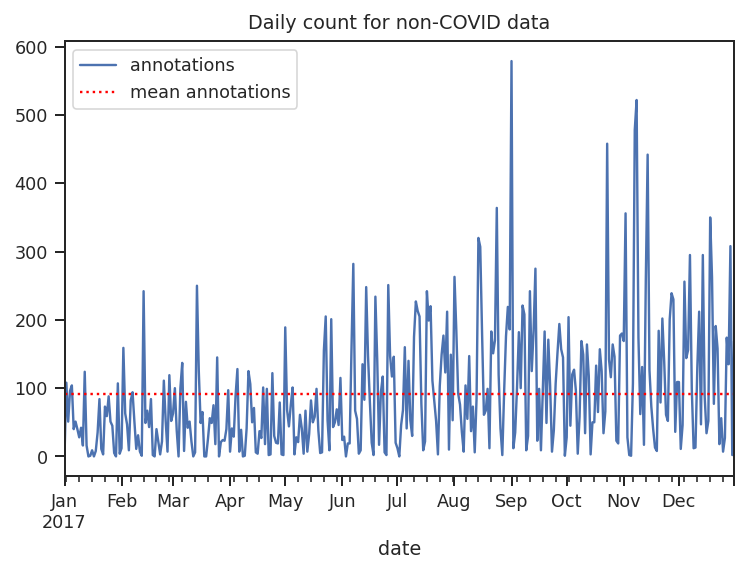

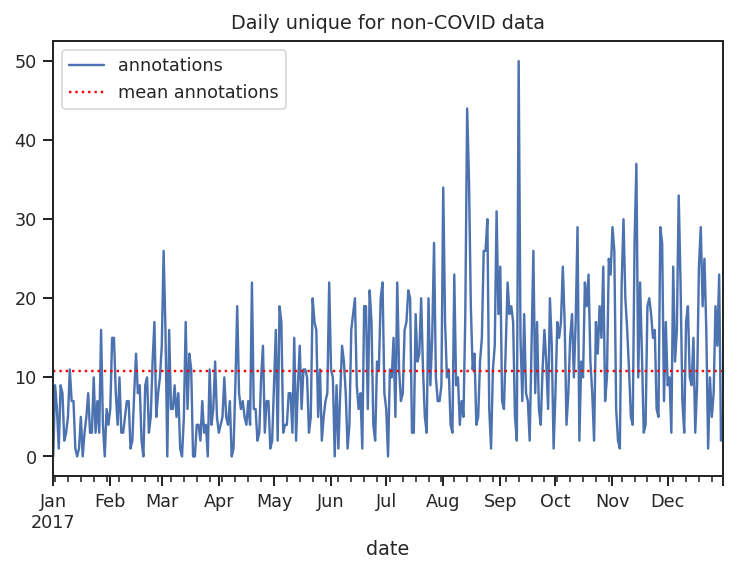

In [10]:
df.groupby('date').count()[['annotations']].plot()
plt.axhline(df.groupby('date').count()['annotations'].mean(), label='mean annotations', c='red', linestyle=':')
plt.legend()
plt.title("Daily count for non-COVID data")
plt.show()

df.groupby('date').nunique()[['annotations']].plot()
plt.axhline(df.groupby('date').nunique()['annotations'].mean(), label='mean annotations', c='red', linestyle=':')
plt.legend()
plt.title("Daily unique for non-COVID data")
plt.show()

In [11]:
df.groupby('date').sum()

,note_id,num_annot,sentence_id,note_index
date,,,,
2017-01-01,83482232816,17.0,153.0,338340611
2017-01-02,341003683396,118.0,43823.0,1131155045
2017-01-03,306887194367,53.0,10777.0,1142537546
2017-01-04,329944450071,102.0,26105.0,1144841330
2017-01-05,324967013750,153.0,18200.0,1232505142
...,...,...,...,...
2017-12-27,1557636028782,364.0,96953.0,3316595392
2017-12-28,1473304616762,309.0,40191.0,3518772397
2017-12-29,1478998699451,415.0,99030.0,3216915224


<AxesSubplot:xlabel='date'>

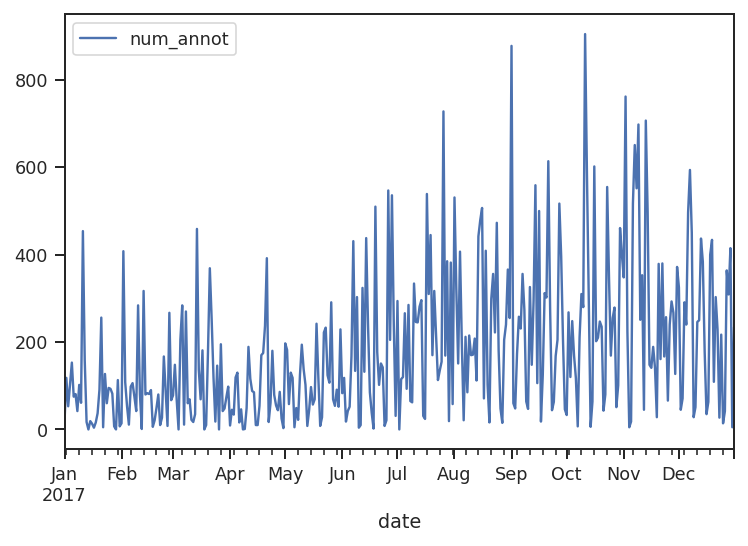

In [12]:
df.groupby('date').sum()[['num_annot']].plot()

In [13]:
df.columns

Index(['date', 'patient_id', 'note_id', 'type', 'num_annot', 'annotator',
       'annotations', 'sentence_id', 'sentence', 'encoding_shape',
       'note_index', 'note'],
      dtype='object')

In [14]:
df.patient_id.nunique(), df.note_id.nunique()

(44502, 1249009)

In [15]:
df.groupby(['patient_id'])['note_id'].nunique().describe()

count    44502.000000
mean        28.066357
std         56.249923
min          1.000000
25%          5.000000
50%         11.000000
75%         27.000000
max       1412.000000
Name: note_id, dtype: float64

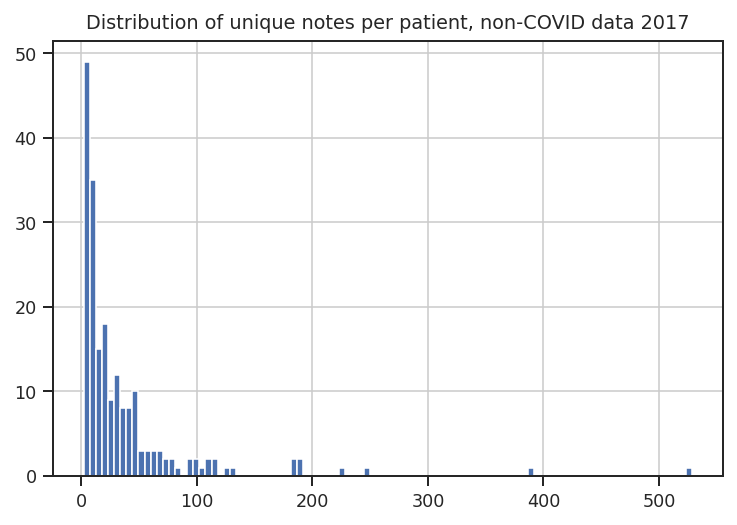

In [16]:
df.groupby(['patient_id'])['note_id'].nunique().head(200).hist(bins=100)
plt.title("Distribution of unique notes per patient, non-COVID data 2017")
plt.show()

In [35]:
df.groupby(['patient_id'])['note_id'].nunique().describe()

count    44502.000000
mean        28.066357
std         56.249923
min          1.000000
25%          5.000000
50%         11.000000
75%         27.000000
max       1412.000000
Name: note_id, dtype: float64

In [37]:
df.groupby(['patient_id'])['note_id'].nunique().median()

11.0

In [17]:
df.groupby(['date'])['note_id'].nunique().describe()

count     365.000000
mean     3421.942466
std      1981.944229
min       526.000000
25%      1942.000000
50%      2693.000000
75%      5601.000000
max      7097.000000
Name: note_id, dtype: float64

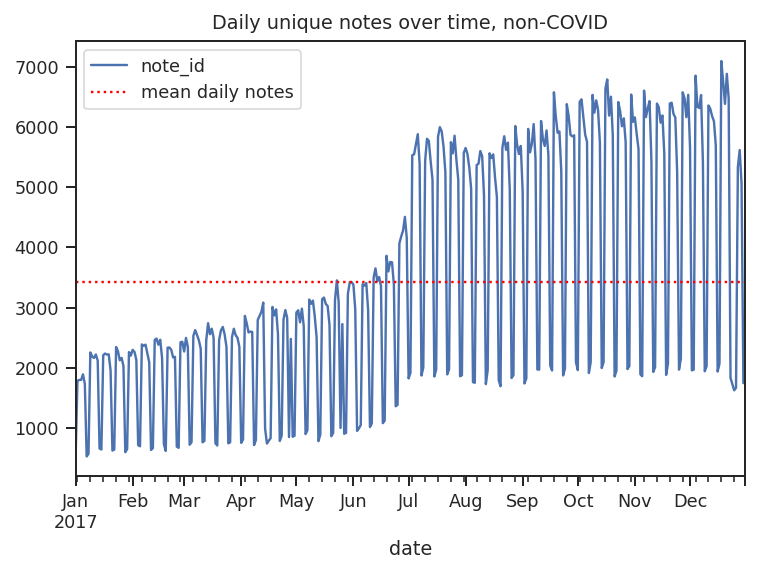

In [18]:
df.groupby(['date'])['note_id'].nunique().plot()
plt.axhline(df.groupby(['date'])['note_id'].nunique().mean(), label='mean daily notes', c='red', linestyle=':')
plt.title("Daily unique notes over time, non-COVID")
plt.legend()
plt.show()

In [19]:
#find what percentage of notes (not sentences) are annotated
_df = df.groupby('note_id').any()
n_annotated = _df[_df.annotations == True].shape[0]
print(n_annotated, _df.shape[0], n_annotated / _df.shape[0])

2276 1249009 0.0018222446755787988


In [20]:
# Find percentage of notes that include annotations for 4 domains
DOMAINS = ['STM', 'INS', 'BER', 'FAC']

def count_domain(s, d):
    assert d in DOMAINS
    if not isinstance(s, str):
        return 0
    if d in s:
        return 1
    return 0
    
_df = df.copy()
for d in DOMAINS:
    _df[f"count_{d}"] = _df['annotations'].apply(count_domain, d=d)

In [21]:
# Look at domain counts across ALL notes
_df.groupby('note_id').sum()[['count_STM', 'count_INS', 'count_BER', 'count_FAC']].describe()

,count_STM,count_INS,count_BER,count_FAC
count,1.249009e+06,1.249009e+06,1.249009e+06,1.249009e+06
mean,1.208958e-03,4.227351e-04,1.721365e-04,7.365840e-04
std,8.208707e-02,3.662903e-02,1.861842e-02,4.478671e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.300000e+01,1.400000e+01,7.000000e+00,1.200000e+01


In [22]:
# Look at domain counts across only annotated notes
_df[~_df.annotations.isna()].groupby('note_id').sum()[
    ['count_STM', 'count_INS', 'count_BER', 'count_FAC']].describe()

,count_STM,count_INS,count_BER,count_FAC
count,2276.000000,2276.000000,2276.000000,2276.000000
mean,0.663445,0.231986,0.094464,0.404218
std,1.805510,0.826355,0.425913,0.968542
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,43.000000,14.000000,7.000000,12.000000


<AxesSubplot:>

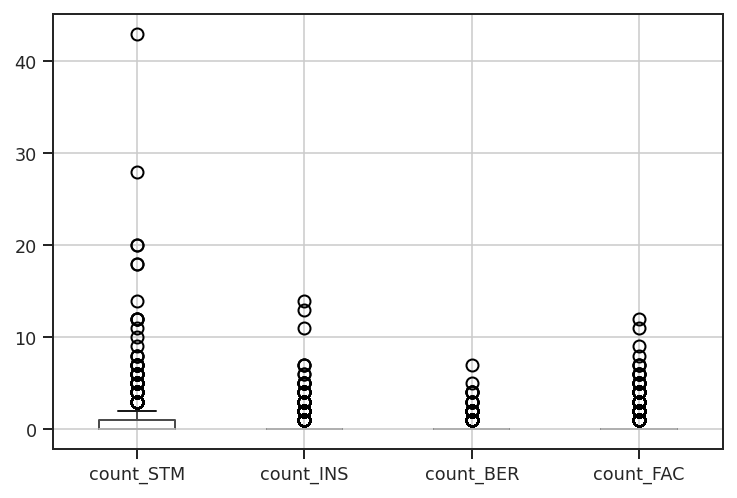

In [23]:
_df[~_df.annotations.isna()].groupby('note_id').sum().boxplot(column=['count_STM', 'count_INS', 'count_BER', 'count_FAC'])

In [24]:
# What fraction of notes are annotated with AT LEAST one of the domains
_df_grouped = _df[~_df.annotations.isna()].groupby(['note_id', 'patient_id']).sum()
_df_grouped['domain_count'] = _df_grouped.count_STM + _df_grouped.count_INS + _df_grouped.count_BER + _df_grouped.count_FAC
n_annot = _df_grouped.shape[0]
df_has_dom = _df_grouped[_df_grouped.domain_count > 0].shape[0]
print(df_has_dom, n_annot, df_has_dom / n_annot)

1307 2276 0.5742530755711776


In [25]:
# How many patients have at least one dom annotation
_df_grouped_patient = _df_grouped[_df_grouped.domain_count > 0].groupby('patient_id').mean()
print(_df_grouped_patient.shape)
_df_grouped_patient.describe()

(1094, 8)


,num_annot,sentence_id,note_index,count_STM,count_INS,count_BER,count_FAC,domain_count
count,1094.000000,1094.000000,1.094000e+03,1094.000000,1094.000000,1094.000000,1094.000000,1094.000000
mean,20.090864,855.071722,2.981442e+05,1.117851,0.416858,0.187005,0.692169,2.413883
std,26.215428,2320.798390,4.733070e+05,2.209297,1.015152,0.582062,1.124578,2.921567
min,2.000000,1.000000,5.600000e+01,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.000000,20.000000,3.001825e+04,0.000000,0.000000,0.000000,0.000000,1.000000
50%,10.000000,154.500000,9.745200e+04,1.000000,0.000000,0.000000,0.000000,2.000000
75%,26.000000,838.000000,3.672011e+05,1.000000,0.500000,0.000000,1.000000,3.000000
max,254.000000,46756.000000,4.705556e+06,43.000000,13.000000,7.000000,12.000000,48.000000


In [26]:
# How many of these patients are useful for timeseries
_df['has_dom_annot'] = False
for pid in tqdm(_df_grouped_patient.reset_index().patient_id):
    _df.loc[_df.patient_id == pid, 'has_dom_annot'] = True
    
_df[_df.has_dom_annot].patient_id.nunique()

100%|██████████| 1094/1094 [02:40<00:00,  6.82it/s]


1094

In [27]:
# How many patients have more than 2 domain annotations over time

def count_positive_doms(xs):
    pos = xs[xs > 0]
    return len(pos)

count_cols = ['count_STM', 'count_INS', 'count_BER', 'count_FAC']

_df_notes = _df[~_df.annotations.isna()].groupby(['note_id', 'patient_id']).sum()
_df_patients = _df_notes.groupby(['patient_id']).agg(count_positive_doms)
# _df_patients
useful_patients = _df_patients[(_df_patients[count_cols] > 1).any(axis=1)].index
print(len(useful_patients), useful_patients[:10])

111 Index(['Z1059959', 'Z1185418', 'Z1197082', 'Z1602520', 'Z168963', 'Z1737941',
       'Z1884641', 'Z1887634', 'Z1922277', 'Z19284'],
      dtype='object', name='patient_id')


In [28]:
_df_ts = _df[_df.patient_id.isin(useful_patients)].groupby(['patient_id', 'note_id', 'date']).sum().reset_index()
_df_ts = _df_ts[_df_ts[count_cols].any(axis=1)]
_df_ts

,patient_id,note_id,date,num_annot,sentence_id,note_index,count_STM,count_INS,count_BER,count_FAC,has_dom_annot
167,Z1059959,165873257,2017-03-14,16.0,2278.0,1416916,0,0,0,1,68
513,Z1059959,227796802,2017-12-28,75.0,6786.0,2368314,0,2,0,3,117
533,Z1185418,160929104,2017-02-27,5.0,4290.0,2616636,0,0,0,1,132
535,Z1185418,169360352,2017-03-27,5.0,3916.0,1833489,0,0,1,1,89
591,Z1185418,179172851,2017-05-06,5.0,190.0,412100,2,0,0,0,20
...,...,...,...,...,...,...,...,...,...,...,...
31074,Z645002,220316050,2017-11-07,120.0,18360.0,5641280,20,1,0,4,272
31118,Z757443,186128857,2017-06-02,2.0,1596.0,1162743,0,1,0,0,57
31267,Z757443,218652813,2017-10-25,2.0,105.0,306015,0,1,0,0,15
31431,Z907925,212081061,2017-09-26,2.0,136.0,271388,1,0,0,0,17


In [29]:
# Of these useful patients (with multiple annotated domains), how many different observations do we have?
_df_ts.groupby('patient_id').count()[count_cols].describe()

,count_STM,count_INS,count_BER,count_FAC
count,111.000000,111.000000,111.000000,111.000000
mean,2.666667,2.666667,2.666667,2.666667
std,1.081525,1.081525,1.081525,1.081525
min,2.000000,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000
75%,3.000000,3.000000,3.000000,3.000000
max,7.000000,7.000000,7.000000,7.000000


In [30]:
# Look at intervals between useful (domain annotated) observations

def spread(arr):
    diffs = []
    for t1, t2 in zip(arr, arr[1:]):
        diffs.append(pd.Timedelta(t2 - t1))
#     print(arr, diffs)
    return np.mean(diffs)
    
_df_ts.groupby('patient_id')['date'].agg(spread).describe()

count                           111
mean     54 days 23:50:29.189189189
std      75 days 15:46:02.238517439
min                 0 days 00:00:00
25%                 7 days 00:00:00
50%                19 days 00:00:00
75%                82 days 04:00:00
max               321 days 00:00:00
Name: date, dtype: object

In [33]:
df.groupby('patient_id')['date'].agg(spread).describe()

/data/homedirs/gianluca/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/homedirs/gianluca/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


count                         44015
mean      9 days 03:25:01.482301322
std      12 days 15:55:29.030688874
min                 0 days 00:00:00
25%                 1 days 09:36:00
50%                 5 days 00:00:00
75%      12 days 07:42:51.428571428
max               305 days 00:00:00
Name: date, dtype: object

In [31]:
df.annotations.value_counts(dropna=False).head(50)

NaN                                                           1429674
type\_Background                                                23362
target                                                           4945
disregard\_file                                                   671
info\_Third party                                                 382
STM 1 | .B152: Stemming                                           293
.D450: Lopen en zich verplaatsen                                  262
.D450: Lopen en zich verplaatsen | FAC 4                          215
view\_Patient                                                     124
FAC 4 | .D450: Lopen en zich verplaatsen                          112
.B152: Stemming | STM 1                                           111
*                                                                 105
STM 3 | .B152: Stemming                                            87
STM 1 | stm\_reaction | .B152: Stemming                            84
STM 1 | .B152: Stemm

In [32]:
DOMAINS = [
    'STM',  # B152 stemming (mood) 0-4
    'INS',  # B455 Inspanningstolerantie (exercise tolerance) 0-5
    'BER',  # D840-859 Beroep en werk (profession and work) 0-4
    'FAC',  # D450 Lopen en zich verplaatsen (walking and movement) 0-5
]

In [36]:
df['patient_id'].nunique()

44502

In [38]:
df['note_id'].nunique()

1249009